In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# camera calibration

This part of the code is used to calculate the object points and images points from provided chessboard test pictures and the function calibrate_camera() uses these points to calibrate camera and returns the matrx and coeffient values

In [2]:
import glob

def calibrate_camera():
    num_col_corners = 9#TODO: may need to change shape
    num_row_corners = 6#TODO: may need to change shape
    object_points = [] #3D object points
    image_points = [] #2D image points
    
    objp = np.zeros((num_row_corners*num_col_corners, 3), np.float32)
    objp[:,:2] = np.mgrid[0:num_col_corners, 0:num_row_corners].T.reshape(-1, 2) #x, y coordinates of object points
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    for frame in images:
        img = mpimg.imread(frame)
        #convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cv2.imwrite('./camera_cal_output/'+frame.split('\\')[-1], gray)
        ret, corners = cv2.findChessboardCorners(gray, (num_col_corners, num_row_corners), None)
        if ret == True:
            image_points.append(corners)
            object_points.append(objp)
    test_img = mpimg.imread('./camera_cal/calibration2.jpg')
    gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
    return cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)

# distortion correction 
Using the matrix and distortion coeffients that we get from camera calibration to un-distort the image

In [3]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()
def correct_distortion(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
images = glob.glob('./camera_cal/calibration*.jpg')
for frame in images:
    img = mpimg.imread(frame)
    cv2.imwrite('./camera_cal_undistorted/'+frame.split('\\')[-1], correct_distortion(img))

# perspective transform

Create source and destination points from test images and calculate perspective transformation matrix

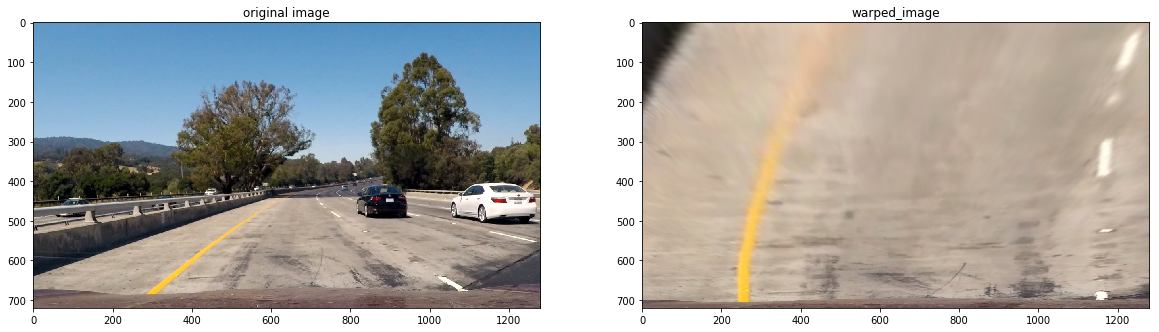

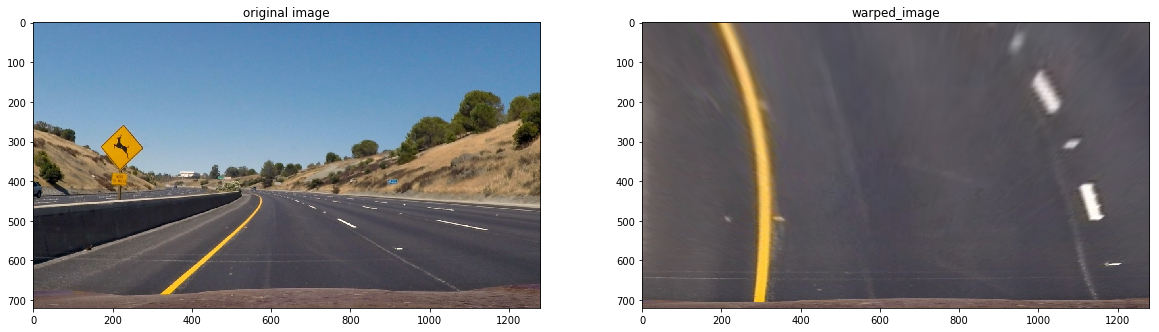

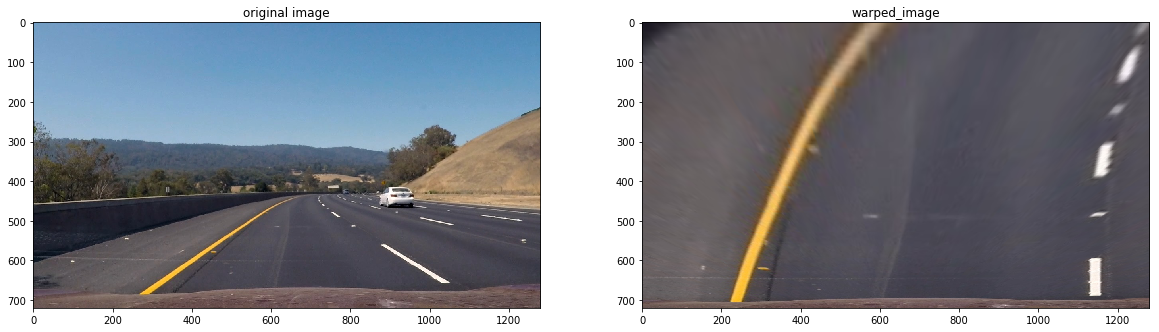

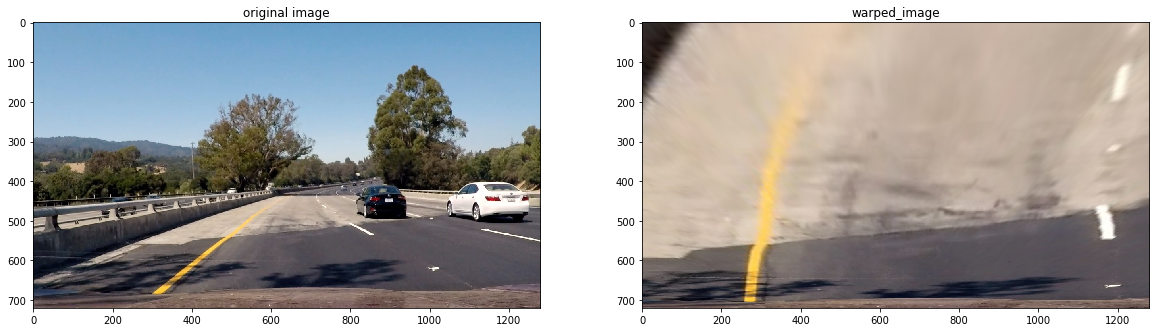

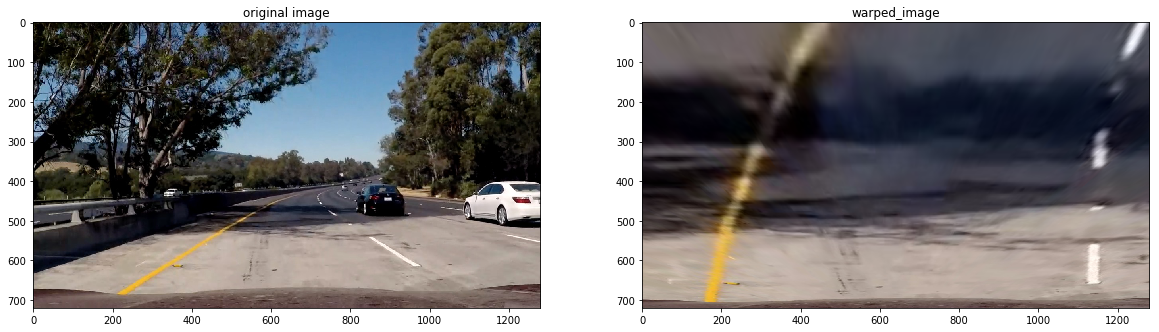

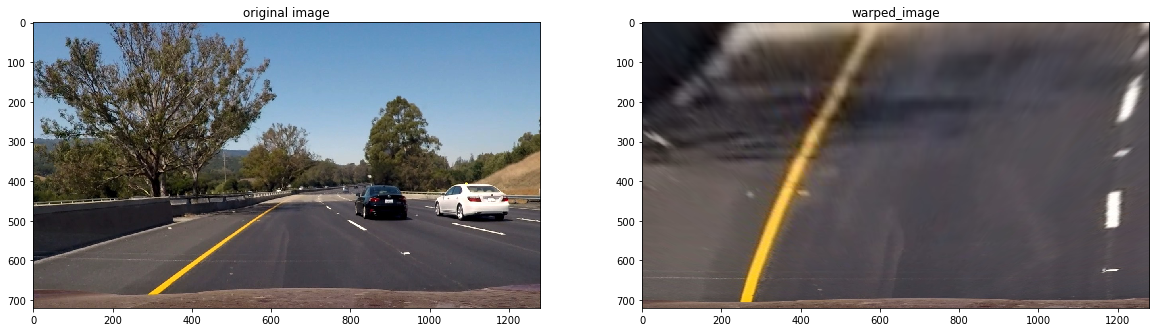

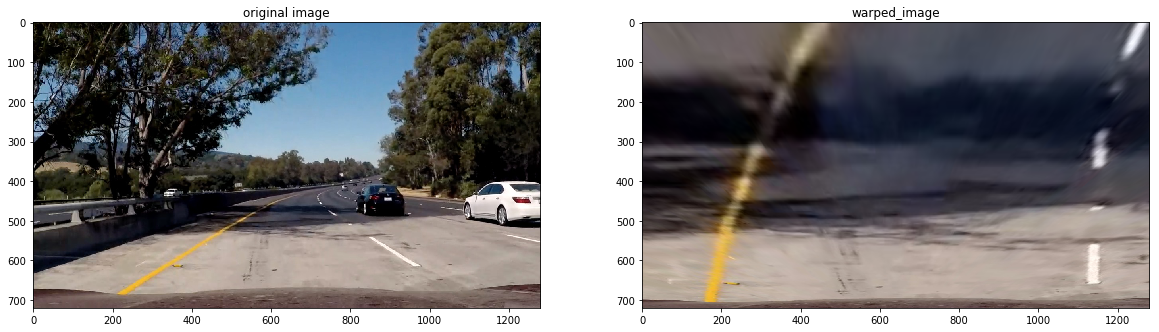

In [5]:
src = np.float32([[700, 453], [1100, 718], [200, 718], [573, 453]])#examine image where lines are straight to get source pointes
dst = np.float32([[1100, 0], [1100, 718], [200, 718], [200, 0]])
M = cv2.getPerspectiveTransform(src, dst)
MInv = cv2.getPerspectiveTransform(dst, src)

def warp_img(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def un_warp_img(img):
    return cv2.warpPerspective(img, MInv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

images = glob.glob('./test_images/test*.jpg')
for frame in images:
    orig_img = mpimg.imread(frame)
    warped = warp_img(orig_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('original image')
    ax1.imshow(orig_img)

    ax2.set_title('warped_image')
    ax2.imshow(warped, cmap='gray')
    cv2.imwrite('./test_images_output_wrap_persp/'+frame.split('\\')[-1], warped)

# create a thresholded binary image

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Take the derivative in x or y given orient = 'x' or 'y'
    x,y = 0,0
    if orient == 'x':
        x = 1
    if orient == 'y':
        y = 1
        
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)#Take the absolute value of the derivative or gradient
    scaled_abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))# 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_abs_sobel)
    grad_binary[(scaled_abs_sobel >= thresh[0]) & (scaled_abs_sobel <= thresh[1])] = 1
    #Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    #Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelX) + np.square(sobelY))
    #Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_mag_sobel)
    #Create a binary mask where mag thresholds are met
    mag_binary[(scaled_mag_sobel >= mag_thresh[0]) & (scaled_mag_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Take the gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    #Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelX)
    abs_sobely = np.absolute(sobelY)
    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    #Create a binary mask where direction thresholds are met
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1]) & (hls[:,:,0] < 100)] = 1#maxout hue to 100
    return binary_output

In [7]:
def get_binary_warped_img(img):
    undist = correct_distortion(img)
    threshold_s_channel = hls_select(undist, thresh=(100 ,255))
    threshold_sobel_x = abs_sobel_thresh(undist, orient='x', sobel_kernel=3, thresh=(30, 150))
    mag_binary = mag_thresh(undist, 3, (25, 255))
    
    combined_binary = np.zeros_like(threshold_sobel_x)
    combined_binary[(threshold_s_channel == 1) | ((mag_binary == 1) & (threshold_sobel_x == 1))] = 1
    binary_warped = warp_img(combined_binary)
    return binary_warped

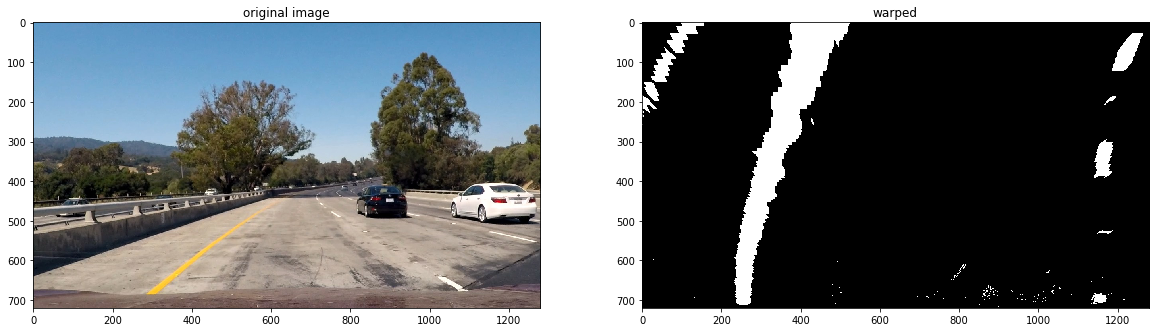

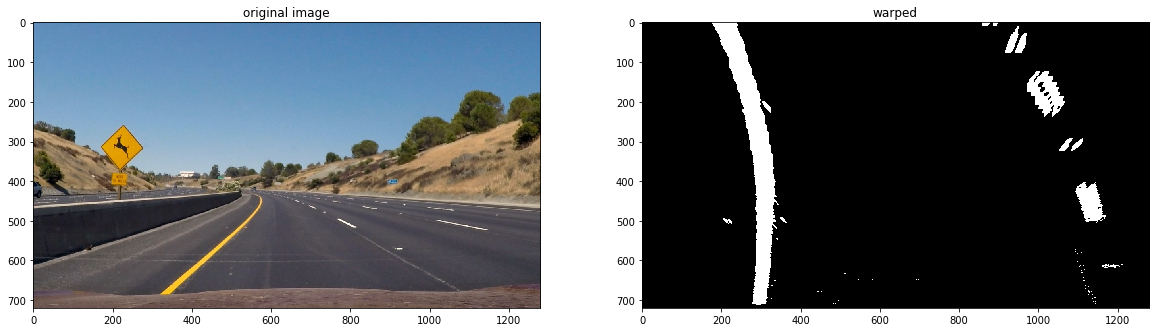

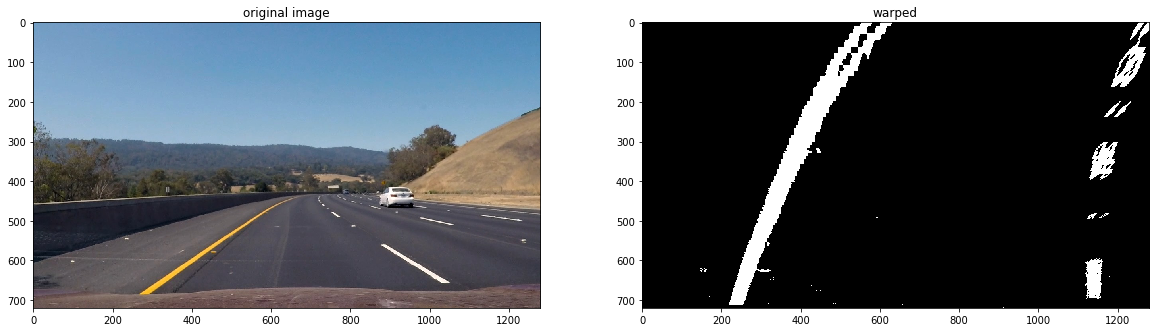

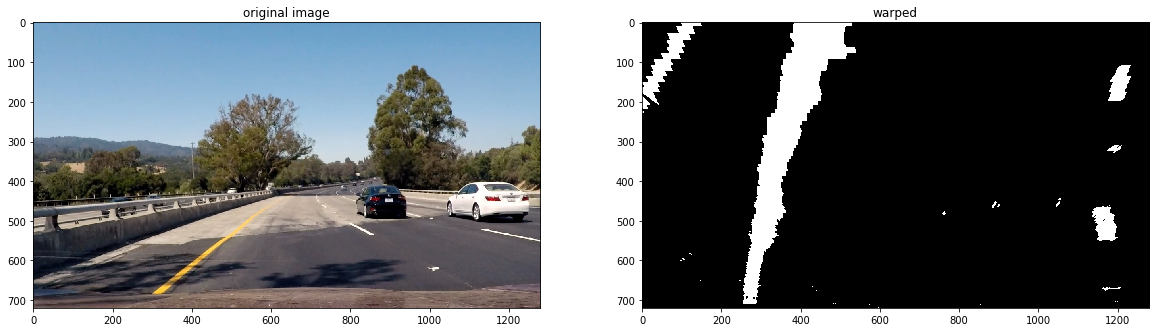

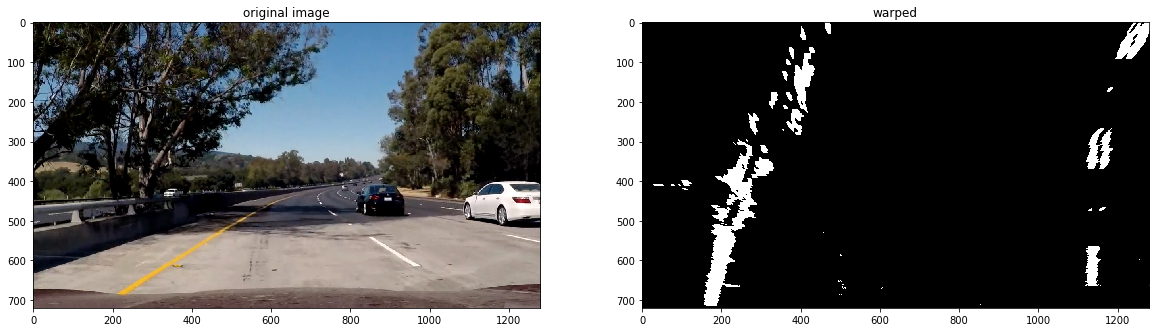

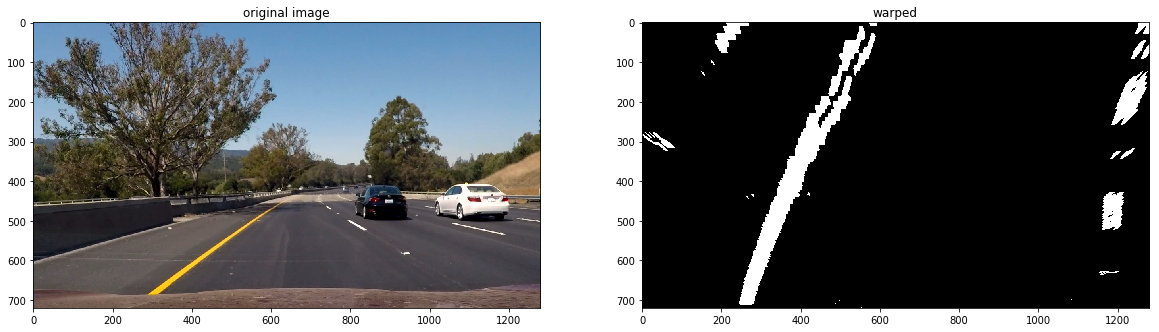

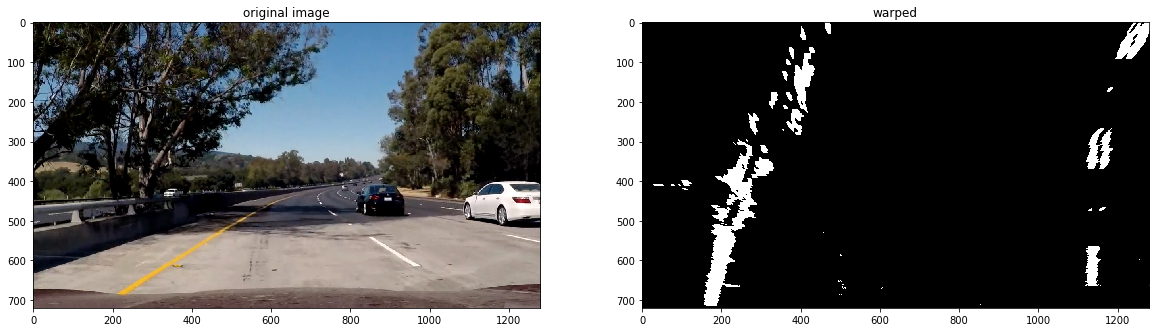

In [8]:
images = glob.glob('./test_images/test*.jpg')
for frame in images:
    orig_img = mpimg.imread(frame)
    warped = get_binary_warped_img(orig_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('original image')
    ax1.imshow(orig_img)

    ax2.set_title('warped')
    ax2.imshow(warped, cmap='gray')
    cv2.imwrite('./test_images_output_wrap_persp/'+frame.split('\\')[-1], warped)

 # Curvature of the lane and vehicle position detection


In [9]:
#reference https://github.com/mxbi/advanced-lane-line-detection
def get_roc(img, poly):
    y_pix_per_m = 30 / 720 # calculate meters per pixel
    x_pix_per_m = 3.7 / 700 # calculate meters per pixel
    
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    fitx = poly[0] * ploty ** 2 + poly[1] * ploty + poly[2]
    
    # Fit new polynomial
    fit_curve = np.polyfit(ploty * y_pix_per_m, fitx * x_pix_per_m, 2)
    
    # Calculate curve radius
    curve_radius = ((1 + (2 * fit_curve[0] * np.max(ploty) * y_pix_per_m + fit_curve[1]) ** 2) ** 1.5) / np.absolute(2 * fit_curve[0])
    return curve_radius

def get_veh_pos(left_fit, right_fit):
    width_between_curves = 3.7  # metres
    frame_height, frame_width = 720, 1280 
    
    # Find the bottom pixel of the lane lines
    l_px = left_fit[0] * frame_height ** 2 + left_fit[1] * frame_height + left_fit[2]
    r_px = right_fit[0] * frame_height ** 2 + right_fit[1] * frame_height + right_fit[2]
    
    # Find the number of pixels per real metre
    scale = width_between_curves / np.abs(l_px - r_px)
    
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (frame_width/2 - midpoint) * scale
    return offset

# Lane pixel detections and lane fitting

In [10]:
def pipeline(img):
    binary_warped = get_binary_warped_img(img)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #roc
    l_radius = get_roc(binary_warped, left_fit)
    r_radius = get_roc(binary_warped, right_fit)
    mean_roc = np.mean([l_radius, r_radius])
    
    #vehicle position
    veh_pos = get_veh_pos(left_fit, right_fit)
    
    # Write radius on image
    cv2.putText(img, 'Radius of Lane Curvature: {}m'.format(int(mean_roc)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    # Write lane offset on image
    cv2.putText(img, 'Vehicle postition to center: {}m'.format(round(veh_pos, 4)), (10, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    # Create an overlay from the lane lines
    overlay = np.zeros_like(out_img).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    un_warp_overlay = un_warp_img(overlay)
    result = cv2.addWeighted(img, 1, un_warp_overlay, 0.3, 0)
    
    return result

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


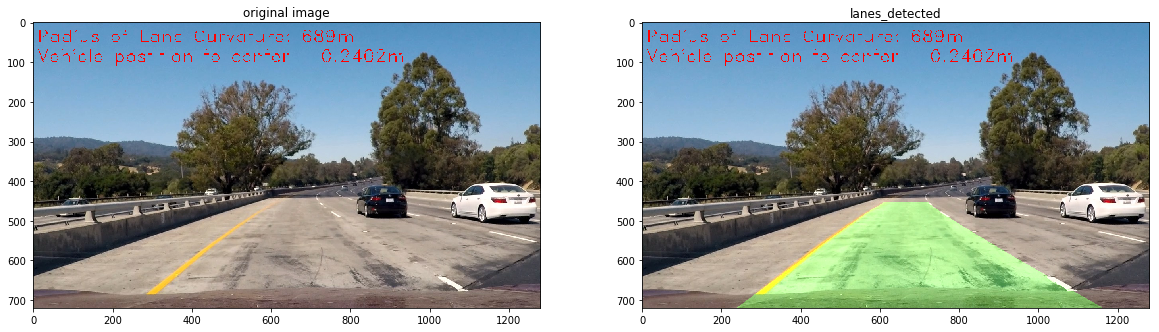

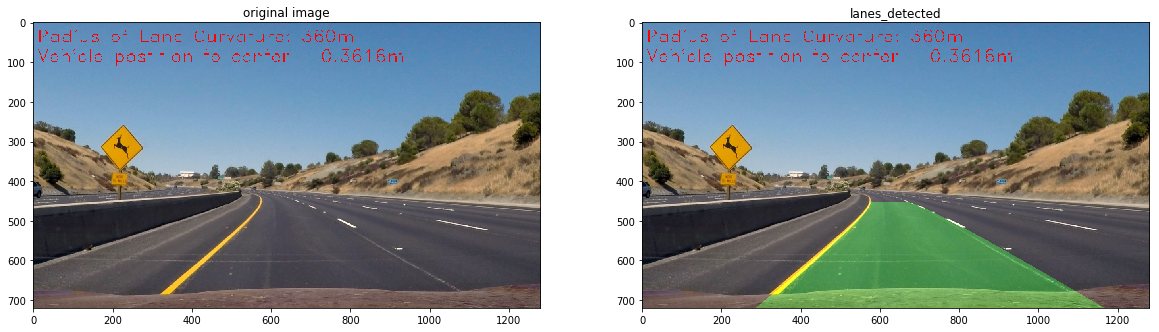

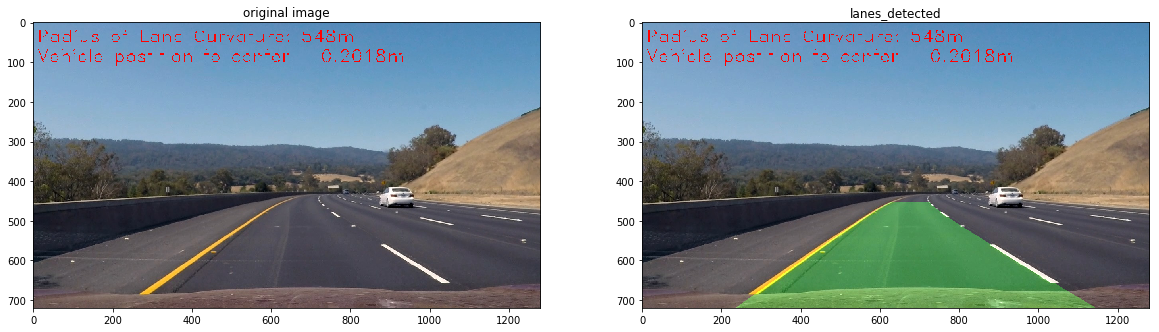

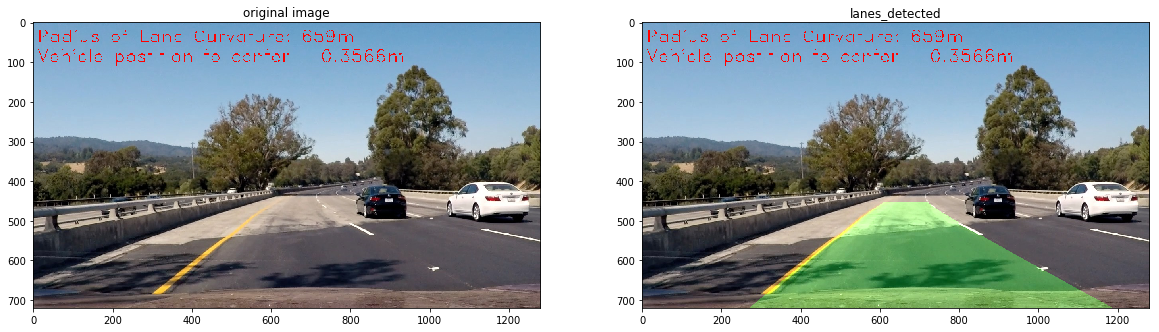

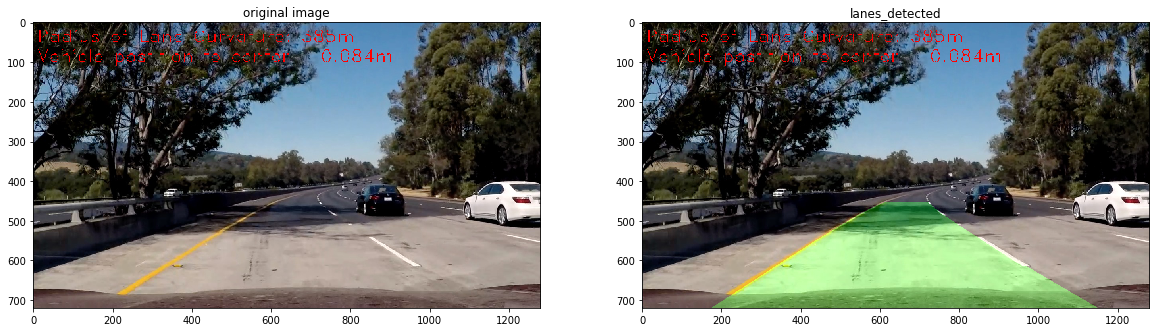

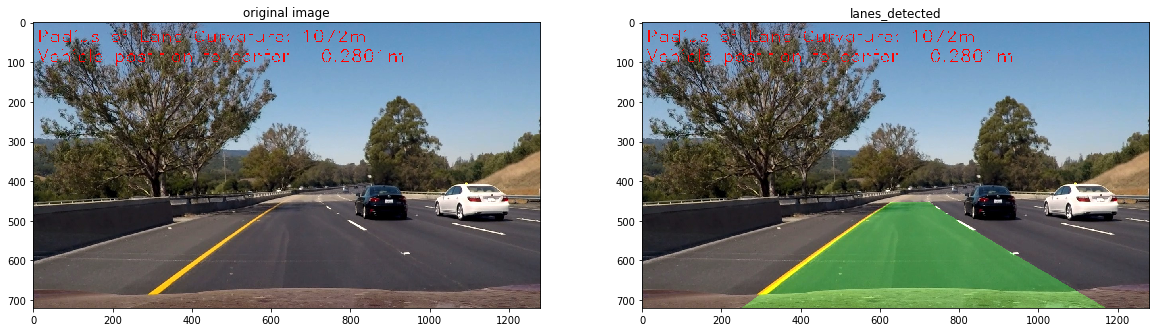

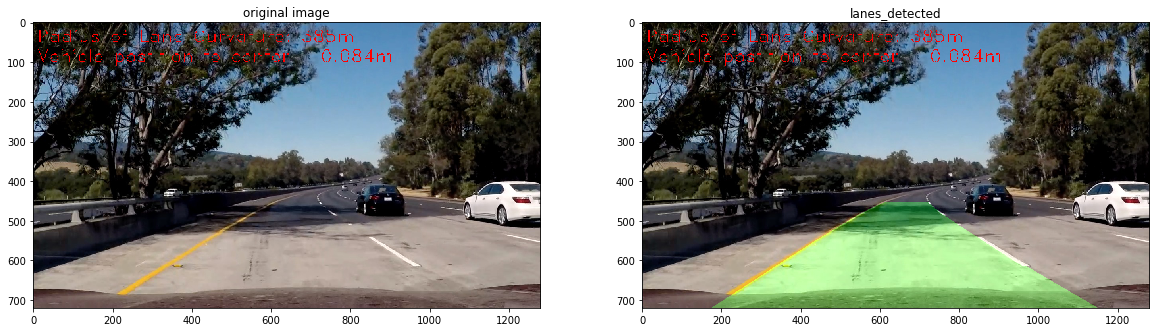

In [11]:
images = glob.glob('./test_images/test*.jpg')
for frame in images:
    orig_img = mpimg.imread(frame)
    lanes_detected = pipeline(orig_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('original image')
    ax1.imshow(orig_img)

    ax2.set_title('lanes_detected')
    ax2.imshow(lanes_detected, cmap='gray')
    cv2.imwrite('./output_images/'+frame.split('\\')[-1], lanes_detected)

In [12]:
from moviepy.editor import VideoFileClip

white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:14<00:00,  6.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 3min 15s


# Output visual display

In [13]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))